In [16]:
import numpy as np

from GRAPE import *
import matplotlib.pyplot as plt
from qiskit import Aer, execute

In [17]:
J = np.zeros((3, 3))
J[0][1] = 0.1385
J[1][2] = 0.01304
J[0][2] = 0.00148

CX = np.eye(4)
CX[2][2] = 0
CX[3][3] = 0
CX[2][3] = 1
CX[3][2] = 1

SWAP = np.eye(4)
SWAP[1][1] = 0
SWAP[2][2] = 0
SWAP[1][2] = 1
SWAP[2][1] = 1

TOFFOLI = np.eye(8)
TOFFOLI[6][6] = 0
TOFFOLI[7][7] = 0
TOFFOLI[6][7] = 1
TOFFOLI[7][6] = 1

C:\Users\Panfe\PycharmProjects\GRAPE\GRAPE.py:94: ComplexWarning: Casting complex values to real discards the imaginary part
  evolution = evolution @ (math.cos(math.pi / 2 * self.J[i][j] * self.time) * np.eye(2 ** self.size,
C:\Users\Panfe\PycharmProjects\GRAPE\GRAPE.py:95: ComplexWarning: Casting complex values to real discards the imaginary part
  dtype=complex) - 1j * math.sin(
C:\Users\Panfe\PycharmProjects\GRAPE\GRAPE.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  matrix = math.cos(self.params[0] / 2) * self._id - 1j * math.sin(self.params[0] / 2) * (
C:\Users\Panfe\PycharmProjects\GRAPE\GRAPE.py:22: ComplexWarning: Casting complex values to real discards the imaginary part
  math.cos(self.params[1]) * self._x + math.sin(self.params[1]) * self._y)


distance: 3.16769 ; time: 64.58


C:\Users\Panfe\PycharmProjects\GRAPE\GRAPE.py:94: ComplexWarning: Casting complex values to real discards the imaginary part
  evolution = evolution @ (math.cos(math.pi / 2 * self.J[i][j] * self.time) * np.eye(2 ** self.size,
C:\Users\Panfe\PycharmProjects\GRAPE\GRAPE.py:95: ComplexWarning: Casting complex values to real discards the imaginary part
  dtype=complex) - 1j * math.sin(


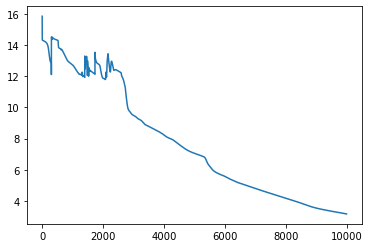

In [18]:
n = 1
m = 10000
k = 4

descents = [GradientDescend(TOFFOLI, k) for _ in range(n)]

for descent in descents:
    descent.noise = 0.05
    descent.randomize_params()
    descent.set_j(J)

losses = [descent.descend(steps=m, track_distance=True) for descent in descents]

for loss in losses:
    plt.plot(np.real(loss))
for i in range(n):
    print("distance:", descents[i].distance.round(6).real, "; time:", descents[i].time.round(2))

In [19]:
for i in range(n):
    for j in range(k):
        print(descents[i].gates[j].time, end=" ")
    print("\n")

circuit = descents[0].to_qiskit()

backend = Aer.get_backend('unitary_simulator')
job = execute(circuit, backend)
result = job.result()
matrix = result.get_unitary(circuit, decimals=2)
print(descents[0].matrix.round(2), "\n" ,matrix.round(2))

circuit.draw()

C:\Users\Panfe\PycharmProjects\GRAPE\GRAPE.py:112: ComplexWarning: Casting complex values to real discards the imaginary part
  circuit.hamiltonian(self.hamiltonian, float(self.time), circuit.qubits)


0 (14.563342234462697+0j) 0 (13.75815456654638+0j) 

[[ 0.89-0.35j -0.04+0.02j -0.04+0.03j  0.23-0.1j  -0.05+0.02j  0.01-0.02j
  -0.01+0.04j  0.1 +0.03j]
 [ 0.03+0.03j  0.95-0.19j  0.12-0.09j  0.06-0.13j  0.03-0.04j  0.01-0.01j
   0.08+0.1j  -0.  +0.06j]
 [-0.03+0.2j  -0.17-0.05j  0.53+0.31j  0.15-0.7j   0.01-0.1j   0.01-0.07j
   0.01+0.11j -0.03-0.09j]
 [-0.12-0.1j  -0.12-0.03j  0.48-0.57j  0.56+0.25j  0.04-0.06j  0.01-0.16j
  -0.01-0.06j -0.01+0.08j]
 [ 0.07+0.02j -0.03-0.01j -0.02-0.07j -0.06-0.08j  0.97+0.13j  0.02+0.07j
  -0.02-0.08j -0.01+0.j  ]
 [-0.01+0.01j -0.  +0.01j -0.03-0.13j -0.  -0.1j  -0.07+0.05j  0.94+0.22j
  -0.08-0.11j  0.05-0.09j]
 [-0.04+0.06j -0.03+0.01j  0.04-0.08j -0.06+0.11j  0.05+0.01j -0.  -0.01j
   0.06+0.52j  0.75-0.36j]
 [-0.05+0.01j -0.07+0.1j  -0.06+0.08j  0.05-0.03j  0.03-0.04j  0.14-0.1j
   0.82-0.01j  0.19+0.48j]] 
 [[ 0.89-0.35j -0.04+0.02j -0.04+0.03j  0.23-0.1j  -0.05+0.02j  0.01-0.02j
  -0.01+0.04j  0.1 +0.03j]
 [ 0.03+0.03j  0.95-0.19j  0.12-0.09

global phase: 3.5665
     ┌──────────────────┐┌──────────────┐┌──────────────────┐┌──────────────┐»
q_0: ┤ R(4.6488,5.0573) ├┤0             ├┤ R(2.4204,2.7813) ├┤0             ├»
     ├──────────────────┤│              │├──────────────────┤│              │»
q_1: ┤ R(7.5902,2.2121) ├┤1 Hamiltonian ├┤ R(3.9266,1.2564) ├┤1 Hamiltonian ├»
     ├──────────────────┤│              │├──────────────────┤│              │»
q_2: ┤ R(6.1188,4.0289) ├┤2             ├┤ R(10.213,3.4595) ├┤2             ├»
     └──────────────────┘└──────────────┘└──────────────────┘└──────────────┘»
«     ┌───────────────────┐┌──────────────┐┌─────────────────┐ ┌──────────────┐»
«q_0: ┤ R(0.88532,2.4793) ├┤0             ├┤ R(8.3819,2.121) ├─┤0             ├»
«     └┬─────────────────┬┘│              │├─────────────────┴┐│              │»
«q_1: ─┤ R(10.432,6.089) ├─┤1 Hamiltonian ├┤ R(9.6171,4.1394) ├┤1 Hamiltonian ├»
«      ├─────────────────┴┐│              │├──────────────────┤│              │»
«q_2: ─┤ R(8.1423,3.8553) ├┤2             ├┤ R(0.5287,3.7132) ├┤2             ├»
«      └──────────────────┘└──────────────┘└──────────────────┘└──────────────┘»
«      ┌──────────────────┐
«q_0: ─┤ R(11.894,1.1454) ├
«      ├──────────────────┤
«q_1: ─┤ R(11.516,6.0695) ├
«     ┌┴──────────────────┤
«q_2: ┤ R(5.6389,0.54792) ├
«     └───────────────────┘

In [20]:
for gate in descents[0].gates:
    print(gate.time, end=" ")
print("\n")


descents[0].make_times_positive()

for gate in descents[0].gates:
    print(gate.time, end=" ")
print("\n")

print(descents[0].distance)
print(descents[0].matrix.round(2))


0 (14.563342234462697+0j) 0 (13.75815456654638+0j) 0 (25.48961019704185+0j) 0 (10.766481082465871+0j) 0 

0 (14.563342234462697+0j) 0 (13.75815456654638+0j) 0 (25.48961019704185+0j) 0 (10.766481082465871+0j) 0 

(3.1676896753637296+0j)
[[ 0.89-0.35j -0.04+0.02j -0.04+0.03j  0.23-0.1j  -0.05+0.02j  0.01-0.02j
  -0.01+0.04j  0.1 +0.03j]
 [ 0.03+0.03j  0.95-0.19j  0.12-0.09j  0.06-0.13j  0.03-0.04j  0.01-0.01j
   0.08+0.1j  -0.  +0.06j]
 [-0.03+0.2j  -0.17-0.05j  0.53+0.31j  0.15-0.7j   0.01-0.1j   0.01-0.07j
   0.01+0.11j -0.03-0.09j]
 [-0.12-0.1j  -0.12-0.03j  0.48-0.57j  0.56+0.25j  0.04-0.06j  0.01-0.16j
  -0.01-0.06j -0.01+0.08j]
 [ 0.07+0.02j -0.03-0.01j -0.02-0.07j -0.06-0.08j  0.97+0.13j  0.02+0.07j
  -0.02-0.08j -0.01+0.j  ]
 [-0.01+0.01j -0.  +0.01j -0.03-0.13j -0.  -0.1j  -0.07+0.05j  0.94+0.22j
  -0.08-0.11j  0.05-0.09j]
 [-0.04+0.06j -0.03+0.01j  0.04-0.08j -0.06+0.11j  0.05+0.01j -0.  -0.01j
   0.06+0.52j  0.75-0.36j]
 [-0.05+0.01j -0.07+0.1j  -0.06+0.08j  0.05-0.03j  0.03-0